## 基本函数定义

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

### 数据准备

In [2]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)

    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col]  # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [3]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"

    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5

    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5

    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5

    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5

    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5

    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5

    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5

    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [4]:
# 数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    # 归一化
    x_scaler = MinMaxScaler()  # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list])
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    # 测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    # 验证集
    if train_ratio != 1:
        valid = df.copy().iloc[int(df.shape[0]*train_ratio)
                        : int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
        valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
        valid_stamp = valid_stamp.transpose(1, 0)
        valid[x_feature_list] = x_scaler.transform(valid)
        xva = valid.values.astype('float32')
        yva = df.copy().iloc[int(df.shape[0]*train_ratio)
                      : int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
        yva[y_feature_list] = y_scaler.transform(yva)
        yva = yva.values.astype('float32')
        valid = [xva, yva, valid_stamp]
    else:
        valid = [np.array(0), np.array(0), np.array(0)]

    # 测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]

    return x_scaler, y_scaler, train, valid, test

In [5]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    stamp = data_list[2]  # 时间戳，不包含未来的时间

    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []

    for index in range(0, len(feature) - seq_len - pred_len + 1, sample_freq):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        # (终点 - 先验序列窗口)
        r_begin = s_end - label_len
        # (终点 + 预测序列长度)
        r_end = r_begin + label_len + pred_len

        # 数据维度
        feat = feature[s_begin: s_end]
        tar = target[r_begin: r_end]
        X.append(np.array(feat))
        y.append(np.array(tar))

        # 时间维度
        xs = stamp[s_begin: s_end]
        ys = stamp[r_begin: r_end]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))

    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()

    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(
        X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)

    return X, y, X_stamp, y_stamp, data_loader

### 模型预测

In [27]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target']
    features = task_args['features']
    mode = task_args['mode'] # 可选'online'和'offline'
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name']
    x_true = predict_args['x_true']
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    pred_len = model_args['pred_len']
    label_len = model_args['label_len']
    seq_len = model_args['seq_len']

    # 检查可用device
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # 预测模式
    if mode == 'online':
        # 生成固定长度的时间范围
        x_true = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
        x_true = x_true[columns]
        timedelta = x_true.index[-1] - x_true.index[-2]  # 时间差
        if label_len != 0:
            y_stamp = pd.date_range(start=x_true.index[-label_len],
                                    end=x_true.index[-label_len] +
                                    timedelta*(label_len+pred_len-1),
                                    freq=freq)
        else:
            y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1),
                                    end=x_true.index[-1] +
                                    timedelta*(label_len+pred_len),
                                    freq=freq)
        x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq)  # x时间戳数据
        x_stamp = x_stamp.transpose(1, 0)
        y_time = y_stamp
        y_stamp = time_features(y_stamp, freq=freq)  # y时间戳数据
        y_stamp = y_stamp.transpose(1, 0)
    
        # 转换类型
        x_true[columns] = x_scaler.transform(x_true)  # 归一化
        x_true = x_true.values.astype('float32')
        x_true = torch.as_tensor(x_true).unsqueeze(0).float()  # 转为张量
        x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
        y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
        # 关闭自动求导功能
        model.eval()  # 一定要有
        with torch.no_grad():
            x_true = x_true.to(device)
            x_stamp = x_stamp.to(device)
            y_stamp = y_stamp.to(device)
            # decoder输入
            B, _, _ = x_true.shape
            dec_inp = torch.zeros((B, pred_len + label_len, len(target))).float().to(device) # 占位符
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy()
            f_dim = -1 if features == 'MS' else 0
            y_pred = y_pred[:, -pred_len:, f_dim:]
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :])  # 反归一化
    
        # 输出为dataframe
        y_pred = pd.DataFrame(
            data=y_pred, index=y_time[-pred_len:], columns=target)
    # 离线模式
    else:
        # 构造数据集
        x_true_ = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
        time_columns = x_true_.index  # 获取时间列
        x_true_ = x_true_.copy()[columns]
    
        # X时间编码
        x_stamp = pd.to_datetime(x_true_.index)
        x_stamp = time_features(x_stamp, freq=freq)
        x_stamp = x_stamp.transpose(1, 0)
    
        # y时间编码，包含未来的时间
        timedelta = x_true_.index[-1] - x_true_.index[-2]  # 时间差
        y_stamp = pd.date_range(start=x_true_.index[0],
                                end=x_true_.index[-1] +
                                timedelta*(pred_len),
                                freq=freq)
        y_stamp = time_features(y_stamp, freq=freq)
        y_stamp = y_stamp.transpose(1, 0)
    
        # X归一化
        x_true_[columns] = x_scaler.transform(x_true_)
        x_true_ = x_true_.values.astype('float32')
    
        # 生成预测张量
        X_true, X_stamp, Y_stamp = [], [], []
        sample_freq = 1
        for index in range(0, len(x_true) - seq_len + 1, sample_freq):
            # 起点
            s_begin = index
            # 终点(起点 + 回视窗口)
            s_end = s_begin + seq_len
            # (终点 - 先验序列窗口)
            r_begin = s_end - label_len
            # (终点 + 预测序列长度)
            r_end = r_begin + label_len + pred_len
    
            # 数据维度
            feat = x_true_[s_begin: s_end]
            X_true.append(np.array(feat))
    
            # 时间维度
            xs = x_stamp[s_begin: s_end]
            ys = y_stamp[r_begin: r_end]
            X_stamp.append(np.array(xs))
            Y_stamp.append(np.array(ys))
        X_true = torch.as_tensor(X_true).float()
        X_stamp = torch.as_tensor(X_stamp).float()
        Y_stamp = torch.as_tensor(Y_stamp).float()
    
        # 模型预测
        model.eval()
        with torch.no_grad():
            X_true = X_true.to(device)
            X_stamp = X_stamp.to(device)
            Y_stamp = Y_stamp.to(device)
    
            # decoder输入
            B, _, _ = X_true.shape
            dec_inp = torch.zeros(
                (B, pred_len + label_len, len(target))).float().to(device)
            y_pred = model(X_true, X_stamp, dec_inp, Y_stamp)
            y_pred = y_pred.cpu().detach().numpy()
            f_dim = -1 if features == 'MS' else 0
            y_pred = y_pred[:, -pred_len:, f_dim:]
    
        # y_pred的形状为 (batch_size, pred_len, feature_dim)
        batch_size, pred_len, feature_dim = y_pred.shape
        time_index = time_columns[seq_len-1:]
    
        # 初始化一个空的 DataFrame，每行是初始时间，每列是递增的预测步
        # 列名格式为 target_i，例如 target_1 表示预测步1，target_2 表示预测步2，依此类推
        columns = [f"{t}_{i+1}" for i in range(pred_len) for t in target]
        result_df = pd.DataFrame(index=time_index, columns=columns)
    
        # 填充 DataFrame，每一行是一个时间点的预测序列
        for i in range(batch_size):
            # 当前时间点的预测
            pred_data = y_scaler.inverse_transform(
                y_pred[i, :, :])  # 形状 (pred_len, feature_dim)
            pred_flattened = pred_data.flatten()  # 将预测结果展平
    
            # 将展平的预测步依次填入当前行
            result_df.iloc[i] = pred_flattened
    
        # 将原始数据与预测数据合并输出
        result_df = result_df.reset_index().rename(columns={'index': time_col})
        select_columns = [time_col] + target
        y_pred = pd.merge(x_true[select_columns], result_df, on=time_col, how='left')

    return y_pred

### 结果分析

In [28]:
# 获取最后一个预测结果
def last_prediction(prediction, pred_len, time_col, target):
    pre_target = [i+'_'+str(pred_len) for i in target]
    prediction_target = prediction[pre_target]
    time = prediction[[time_col]]
    # 向下平移数据
    prediction_shift = prediction_target.shift(pred_len)
    prediction_shift.columns = target
    # 对齐时间
    last_prediction = pd.concat([time, prediction_shift], axis=1)
    
    return last_prediction

In [29]:
# 计算评估指标
def score(x1: pd.DataFrame,
          x2: pd.DataFrame,
          time_col: Union[str, None] = None,
          eval_metrics: str = 'rmse') -> float:
    """
    计算评估指标

    参数说明
    ----------
    x1 : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x2 : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    eval_metrics : {str}
        评估指标值，可选'r2'和'rmse'

    返回值
    -------
    eval_value : {float}
        评估值
    """
    # 规范化数据
    x1 = x1.reset_index(drop=True)
    x2 = x2.reset_index(drop=True)

    # 选取时间列
    if time_col != None:
        no_time_cols = [i for i in x1.columns if i != time_col]
        x1[time_col] = pd.to_datetime(x1[time_col])
        x1_no_time = x1.loc[:, no_time_cols].values.astype('float32')
        x2[time_col] = pd.to_datetime(x2[time_col])
        x2_no_time = x2.loc[:, no_time_cols].values.astype('float32')
    else:
        x1_no_time = x1.values.astype('float32')
        x2_no_time = x2.values.astype('float32')

    # 缺失值删除
    x1_not_nan_index = np.where(~np.isnan(x1_no_time))[0]
    x2_not_nan_index = np.where(~np.isnan(x2_no_time))[0]
    not_nan_index = list(set(x1_not_nan_index) & set(x2_not_nan_index))
    x1_not_nan = x1_no_time[not_nan_index]
    x2_not_nan = x2_no_time[not_nan_index]

    # 计算评估指标
    if eval_metrics == 'r2':
        eval_value = r2_score(x1_not_nan, x2_not_nan)
    elif eval_metrics == 'rmse':
        eval_value = np.sqrt(mean_squared_error(x1_not_nan, x2_not_nan))

    return round(eval_value, 3)

In [30]:
# 绘制子图
def __axs_plot(axs: ndarray,
               nums: int,
               x_in: DataFrame,
               x_out: DataFrame,
               time_col: Union[str, None],
               x_time: ndarray,
               y_label: str,
               threshold: float = 0.05):
    """
    绘制子图函数

    参数说明
    ----------
    axs : {numpy.ndarray}
        绘图示例
    nums : {int}
        绘制子图的个数
    x_in : {DataFrame} of shape (n_samples, n_features)
        实际值
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测值
    time_col : {str}
        时间列
    x_time : {numpy.ndarray}
        x轴的值
    y_label : {str}
        y轴标签
    threshold : {float}
        超限阈值比例

    返回值
    -------
    None
    """
    if nums > 1:
        for nn, ax in enumerate(axs):
            true = x_in.iloc[:, nn].values.astype("float")
            predict = x_out.iloc[:, nn].values.astype("float")
            # 选择数据，同一张子图需要绘制实际值和预测值曲线
            ax.plot(x_time, true)
            ax.plot(x_time, predict)
            # 绘制x轴标签
            if nn == nums - 1:
                ax.set_xlabel(time_col, fontsize=14)
            # 绘制y轴标签
            ax.set_ylabel('value', fontsize=14)
            # 绘制预测阈值带（安全范围的区间）
            ax.fill_between(x_time,
                            predict - predict * threshold,
                            predict + predict * threshold,
                            facecolor='red',
                            alpha=0.3)
            # 绘制图例
            rmse = round(score(pd.DataFrame(true), pd.DataFrame(predict)), 3)
            ax.legend([
                y_label[nn] + " 原始值", y_label[nn] + " 预测值" +
                " rmse: " + str(rmse),
                y_label[nn] + " 预警区间"
            ])
            # x轴文字旋转方向
            for xtick in ax.get_xticklabels():
                xtick.set_rotation(45)
    else:
        # 选择数据，同一张子图需要绘制实际值和预测值曲线
        if type(y_label) == list:
            y_label = y_label[0]
        true = x_in[y_label].values.astype("float").reshape((-1, ))
        predict = x_out[y_label].values.astype("float").reshape((-1, ))
        axs.plot(x_time, true)
        axs.plot(x_time, predict)
        # 绘制x轴标签
        axs.set_xlabel(time_col, fontsize=14)
        # 绘制y轴标签
        axs.set_ylabel('value', fontsize=14)
        # 绘制预测阈值带（安全范围的区间）
        axs.fill_between(x_time,
                         predict - predict * threshold,
                         predict + predict * threshold,
                         facecolor='red',
                         alpha=0.3)
        # 绘制图例
        rmse = round(score(pd.DataFrame(true), pd.DataFrame(predict)), 3)
        axs.legend([
            y_label + " 原始值", y_label + " 预测值" +
            " rmse: " + str(rmse),
            y_label + " 预警区间"
        ])
        # x轴文字旋转方向
        for xtick in axs.get_xticklabels():
            xtick.set_rotation(45)

    return 0


# 绘制曲线
def plot(x_in: DataFrame,
         x_out: DataFrame,
         time_col: Union[str, None] = None,
         plot_cols: Union[List[str], None] = None,
         threshold: float = 0.05) -> None:
    """
    绘制实际值和预测值曲线

    参数说明
    ----------
    x_in : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    plot_cols : {Union[List[str], None]}
        需要绘制的特征列，如果为None，默认不绘制
    threshold : {float}
        预警阈值比例

    返回值
    -------
    None
    """
    # 选择数据
    if plot_cols == None:
        raise ValueError('请选择需要绘制的点，不能为空！')
    no_time_cols = [i for i in plot_cols if i != time_col]
    x_in[time_col] = pd.to_datetime(x_in[time_col])
    x_time = x_in[time_col]
    x_in = x_in[no_time_cols]
    x_out = x_out[no_time_cols]

    # 子图个数
    axs_nums = len(no_time_cols)

    # 分成左右两块画布
    if axs_nums > 1 and axs_nums % 2 == 0:
        # 左右子图个数
        axsLeft_nums = axsRight_nums = int(axs_nums / 2)
        # 创建画布，支持左右布局
        fig = plt.figure(constrained_layout=True,
                         figsize=(20, 4 * axsLeft_nums))
        subfigs = fig.subfigures(1, 2, wspace=0.07)
        # 左子图
        axsLeft = subfigs[0].subplots(axsLeft_nums, 1, sharex=True)
        __axs_plot(axsLeft, axsLeft_nums, x_in.iloc[:, :axsLeft_nums],
                   x_out.iloc[:, :axsLeft_nums], time_col, x_time,
                   no_time_cols[:axsLeft_nums], threshold)
        # 右子图
        axsRight = subfigs[1].subplots(axsRight_nums, 1, sharex=True)
        __axs_plot(axsRight, axsRight_nums, x_in.iloc[:, axsRight_nums:],
                   x_out.iloc[:, axsRight_nums:], time_col, x_time,
                   no_time_cols[axsRight_nums:], threshold)
        # 绘制表头
        fig.suptitle('预警曲线', fontsize=14)
    else:
        # 创建画布，支持单一画布
        if axs_nums == 1:
            no_time_cols = no_time_cols[0]
        fig = plt.figure(constrained_layout=True, figsize=(10, 4 * axs_nums))
        axs = fig.subplots(axs_nums, 1, sharex=True)
        __axs_plot(axs, axs_nums, x_in, x_out, time_col, x_time, no_time_cols,
                   threshold)
        # 绘制表头
        fig.suptitle('预警曲线', fontsize=14)
    plt.show()

    return 0

In [31]:
def __warning(data, width_threshold, false_size):
    """
    width_threshold：滑动窗口长度
    false_size：超限次数
    """
    slide = data.rolling(window=width_threshold).sum()
    slide[slide >= false_size] = 1
    slide[slide < false_size] = 0
    slide[slide.isna()] = 0

    return slide


def output(x_in: DataFrame,
           x_out: DataFrame,
           time_col: Union[str, None] = None,
           threshold: float = 0.05,
           is_real_time_warning: bool = False):
    """
    结果合并输出，包含实际值、预测值、预警结果

    参数说明
    ----------
    x_in : {DataFrame} of shape (n_samples, n_features)
        实际数据
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    threshold : {float}
        预警阈值比例
    is_real_time_warning: {bool}
        是否输出预警结果

    返回值
    -------
    x_out : {DataFrame} of shape (n_samples, n_features)
        合并结果数据
    """
    # 规范化列
    x_in = x_in.reset_index(drop=True)
    x_out = x_out.reset_index(drop=True)
    if time_col != None:
        x_time = x_in[[time_col]]
        x_in = x_in.drop(time_col, axis=1)
        x_out = x_out.drop(time_col, axis=1)
    x_cols = x_in.columns  # 实际列
    x_cols_prediction = [i + '_prediction' for i in x_cols]  # 预测列
    x_cols_warning = [i + '_warning_label' for i in x_cols]  # 残差列

    # 阈值规则
    x_high = x_out + x_out * threshold
    x_low = x_out - x_out * threshold
    # print(x_in.columns)

    # 预警判定
    x_warning = pd.DataFrame(data=np.zeros(x_in.shape), columns=x_cols_warning)
    for i in range(x_high.shape[0]):
        for j in range(x_high.shape[1]):
            value = 1 if (x_in.iloc[i, j] > x_high.iloc[i, j]) or (
                x_in.iloc[i, j] < x_low.iloc[i, j]) else 0
            x_warning.iloc[i, j] = value
    if not is_real_time_warning:
        x_warning = __warning(x_warning, 10, 8)
    x_prediction = pd.DataFrame(data=x_out.loc[:, x_cols].values,
                                columns=x_cols_prediction)
    
    # 合并输出
    if time_col != None:
        x_out = pd.concat([x_time, x_in, x_prediction, x_warning], axis=1)
    else:
        x_out = pd.concat([x_in, x_prediction, x_warning], axis=1)
    print('合并输出为：{0}'.format(x_out))

    return x_out

# 知识蒸馏

知识蒸馏（Knowledge Distillation）是一种利用预训练的模型（通常是大模型）的知识来提升目标任务上小模型的性能的方法。

1. 提升模型精度

如果对目前的网络模型A的精度不是很满意，那么可以先训练一个更高精度的teacher模型B（通常参数量更多，时延更大），然后用这个训练好的teacher模型B对student模型A进行知识蒸馏，得到一个更高精度的A模型。

2. 降低模型时延，压缩网络参数

如果对目前的网络模型A的时延不满意，可以先找到一个时延更低，参数量更小的模型B，通常来讲，这种模型精度也会比较低，然后通过训练一个更高精度的teacher模型C来对这个参数量小的模型B进行知识蒸馏，使得该模型B的精度接近最原始的模型A，从而达到降低时延的目的。

3. 标签之间的域迁移

假如使用狗和猫的数据集训练了一个teacher模型A，使用香蕉和苹果训练了一个teacher模型B，那么就可以用这两个模型同时蒸馏出一个可以识别狗、猫、香蕉以及苹果的模型，将两个不同域的数据集进行集成和迁移。

知识蒸馏采取Teacher-Student模式：将复杂且大的模型作为Teacher，Student模型结构较为简单，用Teacher来辅助Student模型的训练，Teacher学习能力强，可以将它学到的知识迁移给学习能力相对弱的Student模型，以此来增强Student模型的泛化能力。复杂笨重但是效果好的Teacher模型不上线，就单纯是个导师角色，真正部署上线进行预测任务的是灵活轻巧的Student小模型。

知识蒸馏（Knowledge Distillation）的任务不一定需要完全相同，但通常需要一定的相似性以确保知识能够有效传递。知识蒸馏的主要目的是将大模型（教师模型）的知识传递给小模型（学生模型），以便学生模型能够在更小的计算资源下，达到接近教师模型的性能。

任务相似性的要求
- 相同任务：在大多数情况下，知识蒸馏用于相同任务，例如分类、检测或分割。这样，学生模型能够学习教师模型对相同输入的预测表现，确保知识蒸馏效果较好。

- 相似任务：对于一些具有高度相似性的任务，例如教师模型是一个多类别分类器，而学生模型的任务是少数类别的分类器，知识蒸馏也可以有效。此时，教师模型提供的类别概率分布可以帮助学生模型更好地学习这些少数类别之间的区分。

- 不同但相关的任务：如果任务并不完全相同，但具有一定相关性（如从图像分类模型蒸馏到物体检测模型），可以通过特征蒸馏或中间层蒸馏的方式，将教师模型的部分特征或中间输出传递给学生模型。但这种情况下，蒸馏效果可能不如相同任务，因为学生模型不一定能够完全利用教师模型的知识。

知识蒸馏的方式

不同的蒸馏方式也可以让任务不完全相同的模型进行知识传递：

- 软标签蒸馏：教师模型输出的软标签（类别概率分布）作为学生模型的训练目标。这种方式适用于同一任务或类似分类任务。
- 特征蒸馏：在中间层进行特征匹配，将教师模型的中间特征作为学生模型的学习目标。适用于不同但有相似结构的任务。
- 关系蒸馏：学习不同样本间的相对关系，如相似性矩阵等，可以在不同任务间传递结构信息。

## 数据准备

In [6]:
data_path = "../data/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [7]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'temp'],
    "y_feature_list": ['load', 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/Teacher_Student'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 2) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 2) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 2) stamp_test shape: (5261, 4)


In [8]:
# 构造参数字典
params2 = {
    "seq_len": 60,
    "pred_len": 3,
    "label_len": 10,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18350, 60, 2]),y_size: torch.Size([18350, 13, 2]),loader_len: 574
X_size: torch.Size([2569, 60, 2]),y_size: torch.Size([2569, 13, 2]),loader_len: 81
X_size: torch.Size([5199, 60, 2]),y_size: torch.Size([5199, 13, 2]),loader_len: 163


## Teacher模型

In [9]:
# 定义预训练模型
import sys
path = '../scripts/Transformer/'  # 项目所在文件夹
sys.path.insert(0, path)

# 加载模型
from Transformer import Transformer
model_args = {
    'seq_len': 60,
    'pred_len': 3,
    'label_len': 10,
    'output_attention': True,
    'embed': 'timeF', 
    'freq': 'h',
    'd_model': 512,
    'enc_in': 2,
    'dec_in': 2,
    'dropout': 0.1,
    'factor': 3,
    'n_heads': 8,
    'd_ff': 128,
    'e_layers': 2,
    'd_layers': 2,
    'c_out': 2
}
teacher_model = Transformer(**model_args)  # 定义模型实例
model_path = '../outputs/best_models/Transformer/checkpoint.pth'
teacher_model.load_state_dict(torch.load(model_path))  # 加载模型权重

<All keys matched successfully>

## Student模型

In [10]:
# LSTM模型
class LSTM(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, num_layers):
        super().__init__()
        self.pred_len = pred_len
        self.lstm = nn.LSTM(input_size=c_in, hidden_size=d_model, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=d_model, out_features=c_out)
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x, _ = self.lstm(x_enc)
        x = self.linear(x)
        x = x[:, -self.pred_len:, :]  # [B, L, D]

        return x

In [11]:
# 初始化
model_args = {
    'seq_len': 60,
    'pred_len': 3,
    "label_len": 10,
    'd_model': 128,
    'c_in': 2,
    'c_out': 2,
    'num_layers': 2,
}

student_model = LSTM(**model_args)

## 定义损失函数

In [12]:
class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(KnowledgeDistillationLoss, self).__init__()
        # 温度调节项是知识蒸馏中的一种技巧，它用于调整软标签（teacher模型的输出）的分布，以便更有效地传递知识给学生模型。
        self.temperature = temperature 
        self.mse_loss = nn.MSELoss()

    def forward(self, student_outputs, teacher_outputs):
        # 计算 MSE 损失
        mse_loss = self.mse_loss(student_outputs, teacher_outputs)

        # 添加温度调节
        loss = mse_loss / (2 * self.temperature**2)

        return loss

In [13]:
loss_fn = KnowledgeDistillationLoss(temperature=2.0)

## T-S模型训练

In [18]:
def train(train_args):
    # 参数配置
    features = train_args['features']  # 模型预测模式
    teacher_model_name = train_args['teacher_model_name']  # 教师模型名称
    student_model_name = train_args['student_model_name'] # 学生模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'
    pred_len = train_args['pred_len']  # 预测长度
    label_len = train_args['label_len']

    # 检查可用device
    device = torch.device(device)

    # 设置参数优化策略
    teacher_model = teacher_model_name.to(device)
    student_model = student_model_name.to(device)
    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        student_model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)  # 会用到实际数据
            batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # decoder输入
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            # 教师模型不需要参与训练
            with torch.no_grad():
                teacher_outputs = teacher_model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            # 清空梯度
            optimizer.zero_grad()
            # 训练学生模型
            student_outputs = student_model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if features == 'MS' else 0
            teacher_outputs = teacher_outputs[:, -pred_len:, f_dim:]
            student_outputs = student_outputs[:, -pred_len:, f_dim:]
            # 计算时序数据知识蒸馏损失
            train_loss = criterion(teacher_outputs, student_outputs)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        teacher_model.eval()
        student_model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)  # 会用到实际数据
                batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
                # 模型验证
                teacher_outputs = teacher_model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                student_outputs = student_model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if features == 'MS' else 0
                teacher_outputs = teacher_outputs[:, -pred_len:, f_dim:]
                student_outputs = student_outputs[:, -pred_len:, f_dim:]
                # 计算时序数据知识蒸馏损失
                val_loss = criterion(teacher_outputs, student_outputs)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, student_model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper')  # 绘制背景色
        plt.grid(axis='y', linewidth=0.35)  # 绘制网格
        plt.plot(val_losses, linestyle='-', color='#11b3b6')
        plt.plot(train_losses, linestyle='-', color='#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)

    return student_model

  5%|████▏                                                                              | 1/20 [00:25<08:06, 25.62s/it]

Epoch [1/20], Training Loss: 0.0002, Validation Loss: 0.0002
Validation loss decreased (inf --> 0.000169).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:55<08:21, 27.87s/it]

Epoch [2/20], Training Loss: 0.0001, Validation Loss: 0.0001
Validation loss decreased (0.000169 --> 0.000093).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [01:38<09:57, 35.13s/it]

Epoch [3/20], Training Loss: 0.0001, Validation Loss: 0.0001
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [02:13<09:17, 34.84s/it]

Epoch [4/20], Training Loss: 0.0001, Validation Loss: 0.0001
Validation loss decreased (0.000093 --> 0.000073).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [02:46<08:36, 34.42s/it]

Epoch [5/20], Training Loss: 0.0001, Validation Loss: 0.0001
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [03:20<07:57, 34.11s/it]

Epoch [6/20], Training Loss: 0.0001, Validation Loss: 0.0001
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0007938926261462366


 30%|████████████████████████▉                                                          | 6/20 [03:53<09:05, 38.97s/it]

Epoch [7/20], Training Loss: 0.0001, Validation Loss: 0.0001
EarlyStopping counter: 3 out of 3
Early stopping!


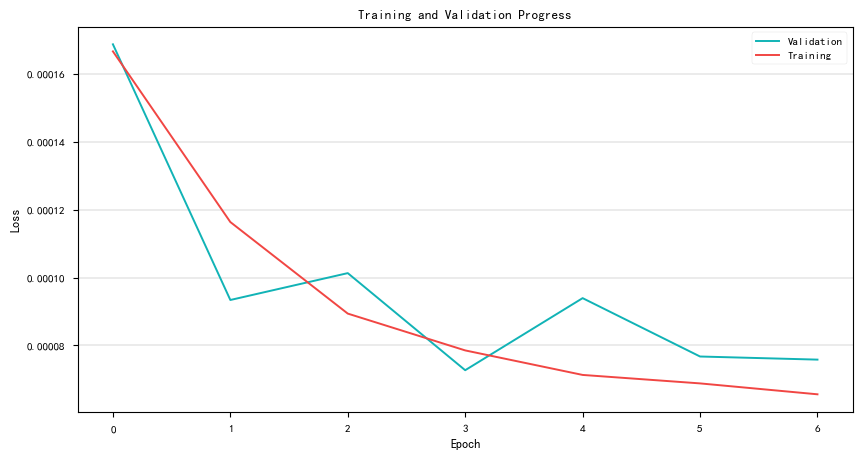

In [19]:
# 构造参数字典
params3 = {
    "train_args": {
        "features": 'M',
        "teacher_model_name": teacher_model,
        "student_model_name": student_model,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": loss_fn, # 知识蒸馏损失函数
        "patience": 3,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/Teacher_Student",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
        "pred_len": 3,
        "label_len": 10
    }
}
student_model = train(**params3)

## Student模型预测

### 在线预测

In [21]:
data_path = "../data/energy.csv"
ts_data = pd.read_csv(data_path).iloc[:60, :]
# 构造参数字典
params5 = {
    "task_args": {
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
        "mode": 'online'
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": LSTM,
        "model_path": "../outputs/best_models/Teacher_Student/checkpoint.pth",
        "x_true": ts_data,
        "scaler_path": '../outputs/scalers/Teacher_Student',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3,
        "label_len": 10,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'num_layers': 2,
    },
}
y_pred = predict(**params5)

In [22]:
y_pred

,load,temp
2012-01-03 12:00:00,3861.940918,24.144377
2012-01-03 13:00:00,3860.435059,21.933071
2012-01-03 14:00:00,3891.848633,19.892427


### 离线预测

In [24]:
data_path = "../data/energy.csv"
ts_data = pd.read_csv(data_path)
ts_data['time'] = pd.to_datetime(ts_data['time'])
# 构造参数字典
params5 = {
    "task_args": {
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
        "mode": 'offline'
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": LSTM,
        "model_path": "../outputs/best_models/Teacher_Student/checkpoint.pth",
        "x_true": ts_data,
        "scaler_path": '../outputs/scalers/Teacher_Student',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3,
        "label_len": 10,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'num_layers': 2,
    },
}
y_pred = predict(**params5)

In [25]:
y_pred

,time,load,temp,load_1,temp_1,load_2,temp_2,load_3,temp_3
0,2012-01-01 00:00:00,2698.0,32.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 01:00:00,2558.0,32.67,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 02:00:00,2444.0,30.00,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 03:00:00,2402.0,31.00,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01 04:00:00,2403.0,32.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26299,2014-12-31 19:00:00,4012.0,18.00,4048.242188,19.777733,3712.823975,19.714087,3401.50293,17.948114
26300,2014-12-31 20:00:00,3856.0,16.67,3712.324707,19.71533,3401.040283,17.949499,3165.301025,16.437784
26301,2014-12-31 21:00:00,3671.0,17.00,3399.689941,17.954216,3164.291016,16.443121,3027.245361,16.978037
26302,2014-12-31 22:00:00,3499.0,15.33,3162.316406,16.45433,3026.52124,16.983215,3008.274414,15.742394


## 结果分析

In [32]:
# 获取最后一个预测结果
params6 = {
    "prediction": y_pred,
    "pred_len": 3,
    "time_col": 'time',
    "target": ['load', 'temp']
}
y_pred = last_prediction(**params6)

In [33]:
# 评估指标
params7 = {
    "x1": ts_data,
    "x2": y_pred,
    "time_col": 'time',
    "eval_metrics": 'rmse'
}
score(**params7)

90.243

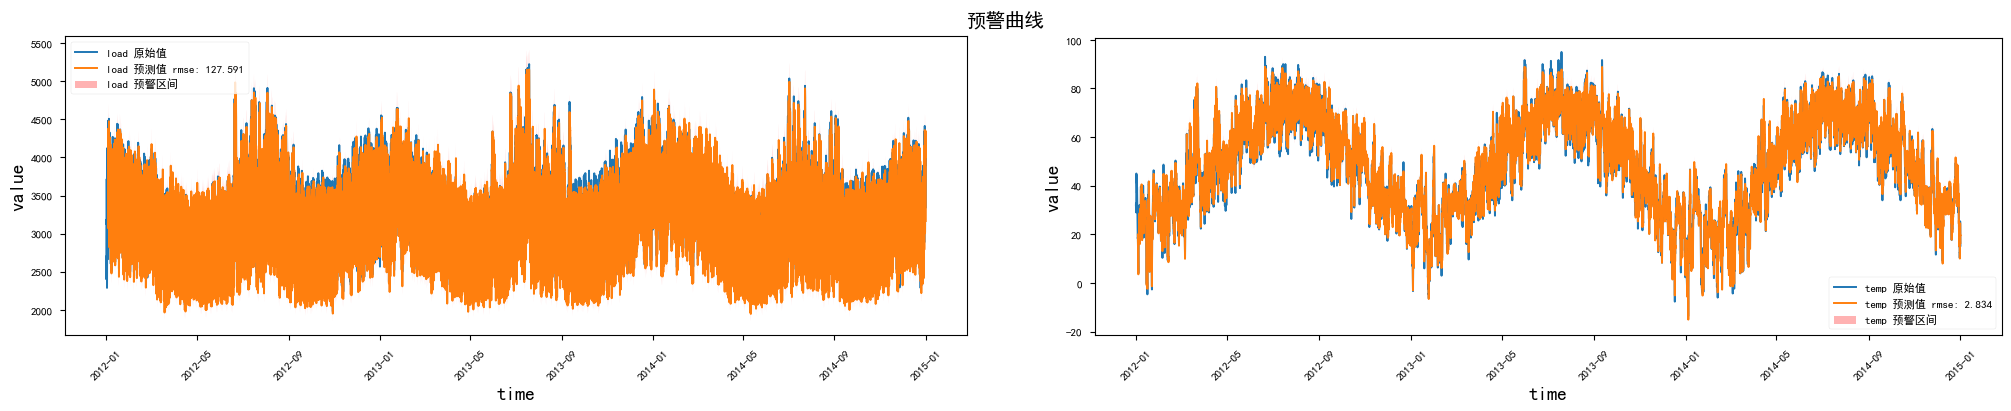

0

In [34]:
param8 = {
    'x_in': ts_data,
    'x_out': y_pred,
    'time_col': 'time',
    'plot_cols': ['load', 'temp'],
    'threshold': 0.05,
}
plot(**param8)

In [35]:
# 合并输出
param9 = {
    'x_in': ts_data,
    'x_out': y_pred,
    'time_col': 'time',
    'threshold': 0.05,
    'is_real_time_warning': True,
}
x_out = output(**param9)

合并输出为：                     time    load   temp load_prediction temp_prediction  \
0     2012-01-01 00:00:00  2698.0  32.00            None            None   
1     2012-01-01 01:00:00  2558.0  32.67            None            None   
2     2012-01-01 02:00:00  2444.0  30.00            None            None   
3     2012-01-01 03:00:00  2402.0  31.00             NaN             NaN   
4     2012-01-01 04:00:00  2403.0  32.00             NaN             NaN   
...                   ...     ...    ...             ...             ...   
26299 2014-12-31 19:00:00  4012.0  18.00     4275.476074       19.427177   
26300 2014-12-31 20:00:00  3856.0  16.67     4047.425537       19.779108   
26301 2014-12-31 21:00:00  3671.0  17.00      3712.69458       19.713352   
26302 2014-12-31 22:00:00  3499.0  15.33      3401.50293       17.948114   
26303 2014-12-31 23:00:00  3345.0  15.33     3165.301025       16.437784   

       load_warning_label  temp_warning_label  
0                     0.0        